# First generate the Master equation data from Clinton:

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import scipy.constants as const
from matplotlib.gridspec import GridSpec

In [2]:
#In units of MHz

gamma_2 = 0.425
gamma_q = 2*gamma_2
gamma_phi = gamma_2/10
kappa = 2.897

chi = -1.22

data = {}

data['gamma_q'] = gamma_q
data['gamma_phi'] = gamma_phi
data['kappa'] = kappa
data['chi'] = chi

In [3]:
exp_data = np.load('July_17_TwoTone_Data.npy', allow_pickle=True)

def S21_Norm(S,S2=[0]):
    if S2[0] == 0:
        S2 = S
    
    a = np.abs(S)
    b = np.mean(np.abs(S2[0:10]))
    c = a - b
    d = np.abs(S2) - b
    NormS21 = c / np.max(d)
    return NormS21

Freqs = exp_data.item()['freq']/1e9
Freq_zoom = exp_data.item()['freq_zoom']/1e9
Freq_wide = exp_data.item()['freq_wide']/1e9

F_mid = np.mean(Freqs)

Freqs = (Freqs - F_mid)*1000 - 5.0
Freq_wide = (Freq_wide - F_mid)*1000 -5.0
Freq_zoom = (Freq_zoom - F_mid)*1000 - 5.0

S21 = exp_data.item()['S21_nomech']
S21_wide = exp_data.item()['S21']
S21_zoom = exp_data.item()['S21_zoom']
Pow = exp_data.item()['Power']

In [4]:
def do_calc(eps_1,eps_2):

    n_ss = []
    q_ss = []
    b_ss = []
    g2 = []
    sz_ss = []
    pop_c = np.zeros((Nb,len(delta)))

    eps_q = eps_1
    eps_r = eps_2
    ii = 0
    
    for d in delta:
        d_q = d
        d_r = 0
        d_b = d + d_qb
        
        H = -0.5*(d_q)*sz
        H += (-d_r+chi)*a.dag()*a
        H += chi*sz*a.dag()*a
        
        H += -d_b*c.dag()*c
        H += eps_q*(sm + sm.dag())
        H += eps_r*(a + a.dag())
        H += g*(sm*c.dag() + sm.dag()*c)
#         H += chi*(g/gaq)*sz*(a.dag()*c + a*c.dag())

        rho_ss = steadystate(H, [c_a, c_s, c_b, c_phi])
        
        rho_phonon = ptrace(rho_ss, 2)
        pop_c[:,ii] = np.real(rho_phonon.diag())
        q_ss.append(expect(sm.dag()*sm, rho_ss))
        n_ss.append(expect(a.dag()*a, rho_ss))
        b_ss.append(expect(c.dag()*c, rho_ss))
        g2.append(expect(c.dag()*c.dag()*c*c, rho_ss)/expect(c.dag()*c, rho_ss)**2)
        ii += 1
        
    return(np.array(n_ss),np.array(q_ss),np.array(b_ss),np.array(g2),pop_c)

In [5]:
def do_calc_nomech(eps_1,eps_2):

    n_ss_1 = []
    q_ss_1 = []
    sz_ss_1 = []
    pop_c = np.zeros((N,1))

    eps_q = eps_1
    eps_r = eps_2
    ii = 0
    
    for d in delta:
        d_q = d
        d_r = 0
        d_b = d + d_qb
        
        H = -0.5*(d_q)*sz
        H += (-d_r+chi)*a.dag()*a
        H += chi*sz*a.dag()*a

        H += eps_q*(sm + sm.dag())
        H += eps_r*(a + a.dag())


        rho_ss = steadystate(H, [c_a, c_s, c_phi])
        
        if d == 0:
            rho_phonon = ptrace(rho_ss, 0)
            pop_c[:,0] = np.real(rho_phonon.diag())
        q_ss_1.append(expect(sm.dag()*sm, rho_ss))
        n_ss_1.append(expect(a.dag()*a, rho_ss))
        ii += 1
        
    return(np.array(n_ss_1),np.array(q_ss_1),pop_c)

In [6]:
N = 8

data['N'] = N
# cavity operators
a = tensor(destroy(N), identity(2))     # Readout Resonator

# Qubit operators
sm = tensor(identity(N), sigmam())
sz = tensor(identity(N), sigmaz())


c_s = np.sqrt(gamma_q) * sm
c_phi = np.sqrt(gamma_phi/2.0) * sz
c_a = np.sqrt(kappa) * a

corr = 7.5

power_db = np.array([-22.0 + corr])
eps_qs = np.sqrt(10**(power_db / 10.0))


P = power_db - corr
ng = 0.00232968*P**2 + 0.12955201*P + 2.46594372
eps_rs = np.sqrt(ng/0.476)

sigma = 0.1
delta_ab = [3.323]

gphonon  = np.array([0.162])
coop = 7.7
gama = (4/(2*coop))*gphonon**2


data['ng'] = ng
data['eps_q'] = eps_qs
data['eps_r'] = eps_rs
data['delta_ab'] = delta_ab
data['sigma'] = sigma

data['gphonon'] = gphonon
data['gamma_bs'] = gama

delta = np.linspace(-30,30,501)

data['delta_1'] = delta

n_ss_1 = np.zeros((len(gphonon),len(delta)))
q_ss_1 = np.zeros((len(gphonon),len(delta)))


# for jj,gams in enumerate(tqdm(gama)):
for ii,ep in enumerate(tqdm(gphonon)):

    d_qb = delta_ab[0]
    n_ss_1[ii,:], q_ss_1[ii,:], pop_a = do_calc_nomech(eps_qs[0],eps_rs[0])

    
data['n_ss_1'] = n_ss_1
data['q_ss_1'] = q_ss_1
data['pop_a'] = pop_a

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
Nb = 8

data['Nb'] = Nb
# cavity operators
a = tensor(destroy(N), identity(2), identity(Nb))     # Readout Resonator
c = tensor(identity(N), identity(2), destroy(Nb))     # Phonon Mode

# Qubit operators
sm = tensor(identity(N), sigmam(), identity(Nb))
sz = tensor(identity(N), sigmaz(), identity(Nb))

c_s = np.sqrt(gamma_q) * sm
c_phi = np.sqrt(gamma_phi/2.0) * sz
c_a = np.sqrt(kappa) * a

delta = np.linspace(-delta_ab[0]-sigma, -delta_ab[0]+sigma,61)
# delta = [-delta_ab[0]]
data['delta'] = delta

n_ss = np.zeros((len(gphonon),len(delta)))
q_ss = np.zeros((len(gphonon),len(delta)))
b_ss = np.zeros((len(gphonon),len(delta)))
g2_ss = np.zeros((len(gphonon),len(delta)))
pop_c = np.zeros((len(gphonon),Nb,len(delta)))

# for jj,gams in enumerate(tqdm(gama)):
for ii,gs in enumerate(tqdm(gphonon)):

    gamma_b = gama[ii]
    g = gs
    c_b = np.sqrt(gamma_b) * c
    d_qb = delta_ab[0]

    n_ss[ii,:], q_ss[ii,:], b_ss[ii,:], g2_ss[ii,:], pop_c[ii,:,:] = do_calc(eps_qs[0],eps_rs[0])


data['n_ss'] = n_ss
data['q_ss'] = q_ss
data['b_ss'] = b_ss
data['g2_ss'] = g2_ss
data['pop_c'] = pop_c

  0%|          | 0/1 [00:00<?, ?it/s]

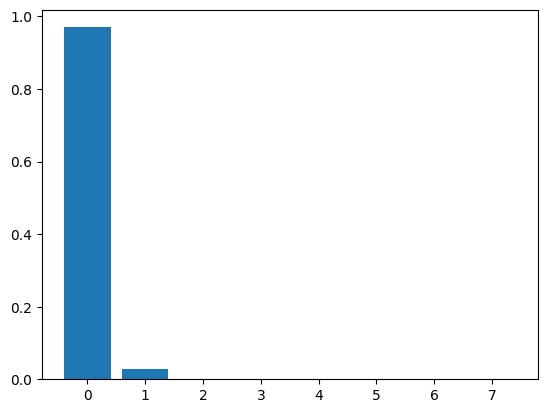

In [8]:
# for jj,gams in enumerate(gama):
for ii,gs in enumerate(gphonon):
    plt.bar(np.arange(0, Nb),pop_c[ii,:,0])

In [9]:
# np.save("August04_newqubit_minus6", data)

In [10]:
delta

array([-3.423     , -3.41966667, -3.41633333, -3.413     , -3.40966667,
       -3.40633333, -3.403     , -3.39966667, -3.39633333, -3.393     ,
       -3.38966667, -3.38633333, -3.383     , -3.37966667, -3.37633333,
       -3.373     , -3.36966667, -3.36633333, -3.363     , -3.35966667,
       -3.35633333, -3.353     , -3.34966667, -3.34633333, -3.343     ,
       -3.33966667, -3.33633333, -3.333     , -3.32966667, -3.32633333,
       -3.323     , -3.31966667, -3.31633333, -3.313     , -3.30966667,
       -3.30633333, -3.303     , -3.29966667, -3.29633333, -3.293     ,
       -3.28966667, -3.28633333, -3.283     , -3.27966667, -3.27633333,
       -3.273     , -3.26966667, -3.26633333, -3.263     , -3.25966667,
       -3.25633333, -3.253     , -3.24966667, -3.24633333, -3.243     ,
       -3.23966667, -3.23633333, -3.233     , -3.22966667, -3.22633333,
       -3.223     ])

In [11]:
Pow[0]

-22.0

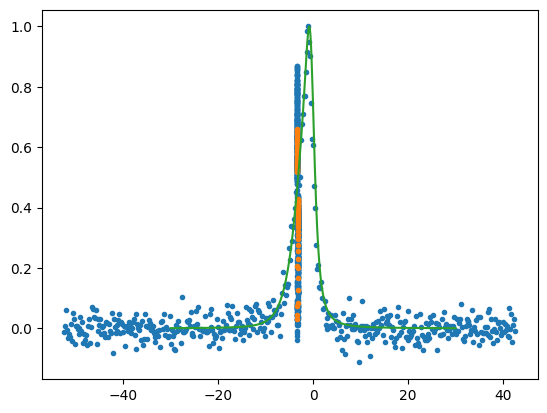

In [12]:
mm = 0
nn = 0

delta_1 = np.linspace(-30,30,501)
# delta = np.linspace(-delta_ab[0]-sigma, -delta_ab[0]+sigma,3)

plt.plot(Freq_wide,S21_Norm(S21_wide[mm],S21[mm]),'.')
plt.plot(delta, q_ss[nn,:]/np.max(q_ss_1[nn]), '.')
plt.plot(delta_1,q_ss_1[nn,:]/np.max(q_ss_1[nn]))

# plt.xlim([-4,-3.5])

(-3.45, -3.2)

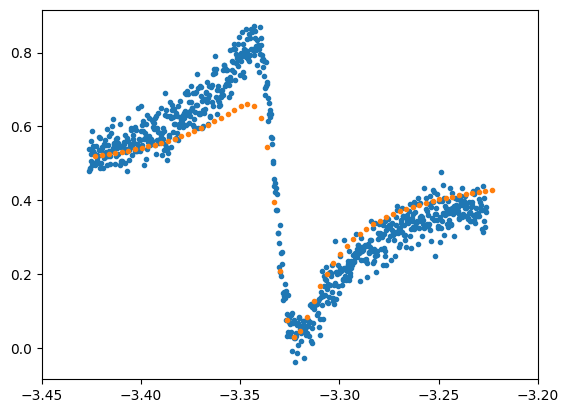

In [13]:
plt.plot(Freq_zoom,S21_Norm(S21_zoom[mm],S21[mm]),'.')
# plt.plot(delta_1, q_ss_1[nn,:]/np.max(q_ss_1[nn]))
plt.plot(delta, q_ss[nn,:]/np.max(q_ss_1[nn]), '.')

plt.xlim([-3.45,-3.2])


In [14]:
# mm = 19
# nn = 0

# delta_1 = np.linspace(-30,30,501)
# delta = np.linspace(-delta_ab[0]-sigma, -delta_ab[0]+sigma,3)

# plt.plot(Freq_wide-2.4,S21_Norm(S21_wide[mm],S21[mm]),'.')
# # plt.plot(delta, q_ss[nn,:]/np.max(q_ss_1[nn]), '.')
# plt.plot(delta_1,q_ss_1[nn,:]/np.max(q_ss_1[nn]))

# # plt.xlim([-4,-3.5])

# plt.plot(Freq_zoom-2.40,S21_Norm(S21_zoom[mm],S21[mm]),'.')
# plt.plot(delta_1, q_ss_1[nn,:]/np.max(q_ss_1[nn]))

# plt.xlim([-5.75,-5.68])
# plt.ylim(0.6,1.05)

# Then we plot the data for -22 dBm drive power:

In [15]:
#imports:
import stlabutils;   # import stlab
import numpy as np
import matplotlib.pyplot  as plt

File_path = "/home/jovyan/steelelab/measurement_data/Triton/Jasper/HBAR_transmon_flipchip/"

/opt/lib/stlabutils/stlabdict.py:908: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if func is '':


In [16]:
file_name = "Hbar_TT_Flux1_1_2023_07_17_09.52.19_segm_Qubit" #-23 ---> +18
# file_name = "Hbar_TT_Flux1_1_2023_08_15_14.27.46_segm_Qubit" #-30 --> -23 
file_pre = File_path+file_name+'/'+file_name+'.dat';    file = stlabutils.readdata.readdat(file_pre,delim=',')
S21_zoom = []; S21_wide=[]; Drive_powers = []; S21 = [];  
hbar_freq = 6.06413e9; df_hbar = 200e3

plot_whileLoop = 'N'  #'Y' or 'N'

for i in np.arange(len(file)):
    ##load DATA
    Freq = file[i]['Frequency (Hz)'].values; S21Real = file[i][' CH2_S21_S1re ()'].values
    S21Imag = file[i][' CH2_S21_S1im ()'].values   
    # probably a better way of representing the data!
    S21dB_2 = np.abs(S21Real + 1j*S21Imag)

    pnt_1 = 245;     pnt_2 = 1047 #HBAR 1
    if plot_whileLoop == 'Y':
        #plot: 
        fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))    
        ax1.set_title('Drive power '+str(file[i][' Drive Power (dBm)'].values[0])+'dBm',fontsize = 40)

        ax1.plot(Freq/1e9,S21dB_2,'.',label='Data S21')
        ax1.set_xlabel('Frequency [GHz]');   ax1.set_ylabel('$|S21|$ [A.U.]'); ax1.legend(loc='upper right')

        ax2.plot((np.array(Freq[pnt_1:pnt_2])- hbar_freq)/1e3,S21dB_2[pnt_1:pnt_2],'r.',label='Data S21, HBAR 1')
        ax2.set_ylabel('$|S21|$ [A.U.]'); ax1.legend(loc='upper right')
        ax2.set_xlabel('Frequency [kHz]'); 
        
    Drive_powers.append(file[i][' Drive Power (dBm)'].values[0])
    S21_zoom.append(S21dB_2[pnt_1:pnt_2])
    S21_wide.append(np.concatenate((S21dB_2[:pnt_1],S21dB_2[pnt_2:])))
    S21.append(S21dB_2)
    


['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs']


### Plotting data for given input power and normalized S21:

(6.06403, 6.06423)

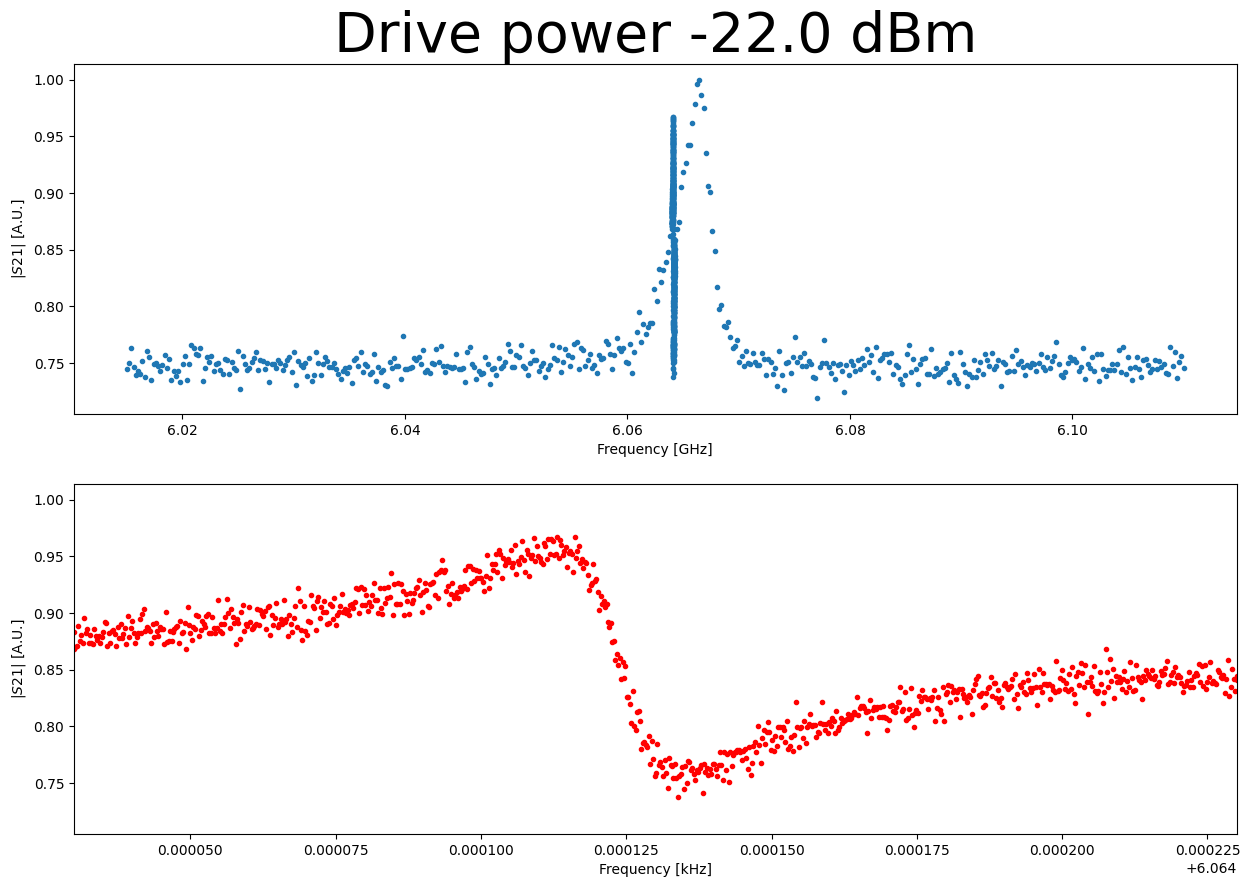

In [17]:
#fill in sought input power to find index "idx"
Pow_dBm = -22
idx = min(range(len(Drive_powers)), key=lambda i: abs(Drive_powers[i]-Pow_dBm))
#correct freq to get it in GHz
Freq_plt = Freq/1e9
#index number for given points for phonon mode to get corresponding frequencies
pnt_1 = 245;     pnt_2 = 1046 #index number 

#Get S21 and used power to corresponding input power from "Pow_dBm":
S21dB = np.abs((file[idx][' CH2_S21_S1re ()'].values) + 1j*(file[idx][' CH2_S21_S1im ()'].values ))
pow_print = file[idx][' Drive Power (dBm)'].values[0]


## PLOT ##
#Use "idx" to plot corresponding, normalized S21 value of qubit+phonon and phonon only~
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
ax1.set_title('Drive power '+str(pow_print)+' dBm',fontsize = 40)

ax1.plot(Freq_plt,S21dB/np.max(S21dB),'.',label='Data S21')
ax1.set_xlabel('Frequency [GHz]');   
ax1.set_ylabel('$|S21|$ [A.U.]'); # ax1.legend(loc='upper right')

ax2.plot(Freq_plt,S21dB/np.max(S21dB),'r.',label='Data S21, HBAR 1')
ax2.set_ylabel('$|S21|$ [A.U.]'); 
ax2.set_xlabel('Frequency [kHz]');  # ax2.legend(loc='upper right')
ax2.set_xlim([Freq_plt[pnt_1],Freq_plt[pnt_2]])

### Same plotting, but now centered around phonon mode, and S21 shifted down before norm:

6066438201.8


(-105.0, 95.0)

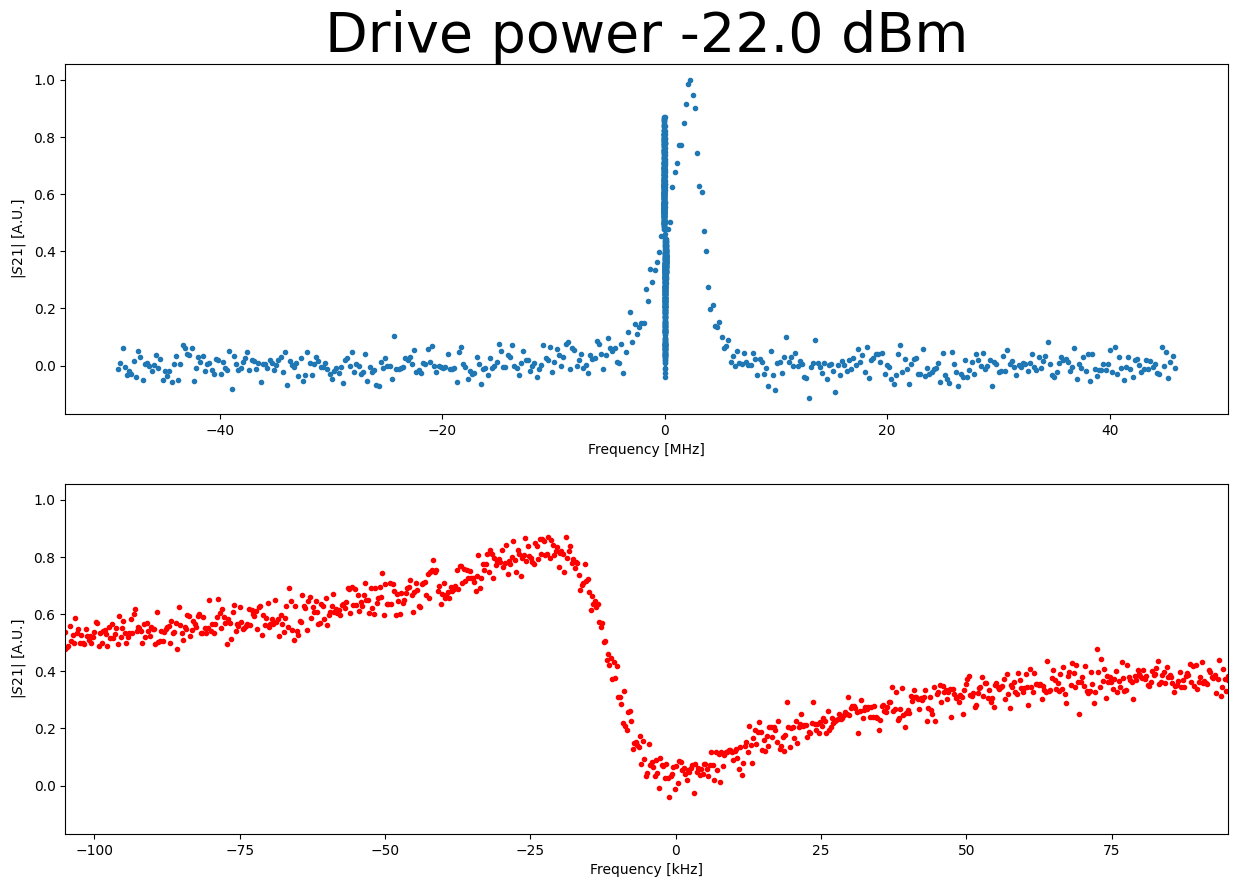

In [18]:
#phonon mode frequency:
f_ph = 6.064135e9 # [Hz]

#fill in sought input power to find index "idx"
Pow_dBm = -22
idx = min(range(len(Drive_powers)), key=lambda i: abs(Drive_powers[i]-Pow_dBm))

#correct frequency ranges
Freq_plt = (Freq - f_ph)/1e6
Freq_plt_2 = (Freq - f_ph)/1e3


#index number for given points for phonon mode to get corresponding frequencies
pnt_1 = 245;     pnt_2 = 1046 #index number 

#Get S21 and used power to corresponding input power from "Pow_dBm":
S21dB = np.abs((file[idx][' CH2_S21_S1re ()'].values) + 1j*(file[idx][' CH2_S21_S1im ()'].values ))
pow_print = file[idx][' Drive Power (dBm)'].values[0]

#shifting S21 data down
S21dB = S21dB-np.average(S21dB[0:100])

#find frequency of qubit (top of the S21 data):
f_qubitData = Freq[np.argmax(S21dB)]
print(f_qubitData)


## PLOT ##
#Use "idx" to plot corresponding, normalized S21 value of qubit+phonon and phonon only~
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
ax1.set_title('Drive power '+str(pow_print)+' dBm',fontsize = 40)

ax1.plot(Freq_plt,S21dB/np.max(S21dB),'.',label='Data S21')
ax1.set_xlabel('Frequency [MHz]');   
ax1.set_ylabel('$|S21|$ [A.U.]'); # ax1.legend(loc='upper right')

ax2.plot(Freq_plt_2,S21dB/np.max(S21dB),'r.',label='Data S21, HBAR 1')
ax2.set_ylabel('$|S21|$ [A.U.]'); 
ax2.set_xlabel('Frequency [kHz]');  # ax2.legend(loc='upper right')
ax2.set_xlim([Freq_plt_2[pnt_1],Freq_plt_2[pnt_2]])

<font color='blue'>
    
# Here, we start to import code from "Mean_Field Dynamics Spectrum_by_VB.ipynb"

</font>

In [19]:
## Imports
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import scipy.constants as const
from scipy.integrate import odeint
from matplotlib import rc
from scipy.optimize import fsolve
from math import exp
import h5py
from mpl_toolkits import mplot3d
%matplotlib inline

## Functions:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

#Mean field steady-state equations for the effective master equation
def MFEquationsEffective(vars, *data):
    
    bR, bI, smR, smI, sz = vars
    bb = bR + 1j*bI
    smi = smR + 1j*smI
    
    eps_q, eps_r, dr, dq, dqb, chi, gb, gamma_b, kappa, gamma_1, gamma_phi = data
    #The phonon is always driven in resonance
    db = 0.
    gamma_2 = gamma_phi + gamma_1/2
    algs = 1j*eps_r/(1j*(dr + chi) - kappa/2)
    ales = 1j*eps_r/(1j*(dr - chi) - kappa/2)
    
    Bss = 2*chi*np.real(algs*np.conj(ales))
    Gss = 2*chi*np.imag(algs*np.conj(ales))
    
    eqb = (1j*db - gamma_b/2)*bb - 1j*gb*smi
    eqsmi = (1j*(dq - Bss) - (gamma_2+Gss) )*smi + 1j*gb*bb*sz +1j*eps_q*sz
    eqsz = -4*gb*np.imag(np.conj(bb)*smi)-4*eps_q*np.imag(smi)-gamma_1*(sz+1)
    
    return [np.real(eqb),np.imag(eqb), np.real(eqsmi),np.imag(eqsmi), eqsz]

#Mean field equations for the effective master equation, this function will be used to compute
#the dynamics of the system
def MFEquationsDynamics(z, t, eps_q, eps_r, dr, dq, dqb, chi, gb, gamma_b, kappa, gamma_1, gamma_phi):
    
    bR = z[0]
    bI = z[1]
    smR = z[2]
    smI = z[3]
    sz = z[4]
    
    bb = bR + 1j*bI
    smi = smR + 1j*smI
    
    
    #The phonon is always driven in resonance with the qubit drive!
    db = 0.
    gamma_2 = gamma_phi + gamma_1/2
    
    algs = 1j*eps_r/(1j*(dr + chi) - kappa/2)
    
    xie = 1j*(dr - chi) - kappa/2
    exie = np.exp(xie*t)
    ale = algs*exie +(1-exie)*1j*eps_r/xie

    
    Bss = 2*chi*np.real(algs*np.conj(ale))
    Gss = 2*chi*np.imag(algs*np.conj(ale))
    
    eqb = (1j*db - gamma_b/2)*bb - 1j*gb*smi
    eqsmi = (1j*(dq - Bss) - (gamma_2+Gss) )*smi + 1j*gb*bb*sz +1j*eps_q*sz
    eqsz = -4*gb*np.imag(np.conj(bb)*smi)-4*eps_q*np.imag(smi)-gamma_1*(sz+1)
    
    return [np.real(eqb),np.imag(eqb), np.real(eqsmi),np.imag(eqsmi), eqsz]

In [20]:
#Parameters - here everything is in GHz.

#Qubit decay and dephasing
g2 = 0.425/10**(3)
gamma_1 = 2*g2
gamma_phi = g2/10

#cavity decay
kappa = 2.897/10**(3)

#phonon-qubit coupling
gb=  0.162/10**(3)

#phonon-qubit cooperativity
Co = 7.7/10**3

#phonon decay
gamma_b = 4*gb**2/(2*Co)

#dispersive cavity-qubit coupling
chi = -1.22/(10**3)

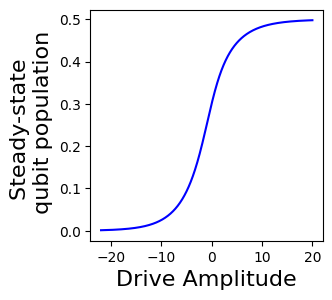

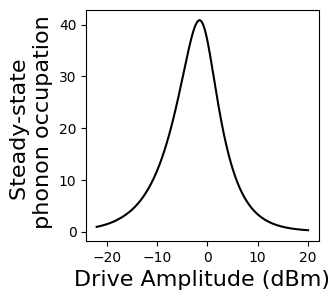

In [21]:
corr = 7.5
power0 = np.linspace(-22., 20., 1000)
# power0 = [-22.]


szER = []
nbER= []
sxER = []
syER = []
nbS = []


#This is an initial guess that you have to give for the solver
s0E = [0., 0., 0., 0., -1]

dets = []

for poww in power0:
    powwdb = poww+corr
    eq = np.sqrt(10**(powwdb / 10.0))/10**(3)
    P = poww
    ng = 0.00232968*P**2 + 0.12955201*P + 2.46594372
    er = np.sqrt(ng/(0.476))/10**3
#    dqb = wq - wb
    if poww < -18:
        dqb = 3.325/10**3
    else:
        dqb = (5.584 +0.1335*P)/10**3
    #Detuning scheme
    dr = -chi
    #Qubit-drive detuning detuning wd - wq = wb - wq = - dqb
    dq = -dqb
    #when we know the difference between qubit and phonon mode from data (see above cells) uncommand the below!
#     dq = ((f_qubitData - f_ph)/1e6)/10**3
    
    data = (eq, er, dr, dq, dqb, chi, gb, gamma_b, kappa, gamma_1, gamma_phi)
    solE = fsolve(MFEquationsEffective, s0E, args=data)
    s0E = solE
    szER.append(solE[-1])
    sxER.append(2*solE[2])
    syER.append(-2*solE[3])
    nbER.append(solE[0]**2 + solE[1]**2)
    
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(power0, (1+np.array(szER))/2,  'b')
ax.set_xlabel('Drive Amplitude',fontsize = 16)
ax.set_ylabel('Steady-state \n qubit population',fontsize = 16)
plt.show()

#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(power0, np.array(nbER),  'k')
ax.set_xlabel('Drive Amplitude (dBm)',fontsize = 16)
ax.set_ylabel('Steady-state \n phonon occupation',fontsize = 16)
plt.show()

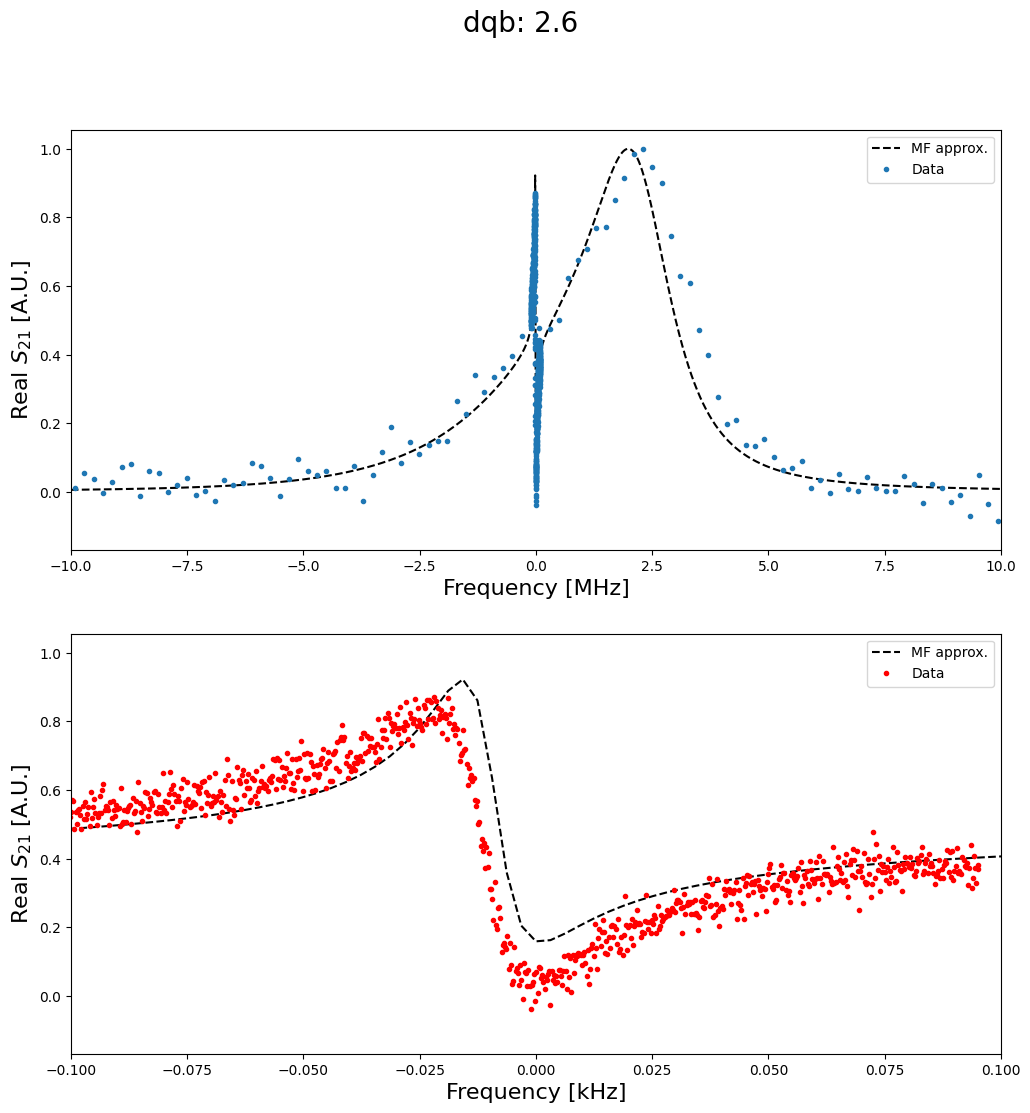

In [22]:
## Setup:
Reverse_plot = 'Y' #'N' or 'Y'

# dqb_list = np.arange(2.3, 3.3, 0.1)  # dqb_list = [2.3, 3.3]
dqb_list = [2.6]

n = 5000001  #5000001
# n = 50001    ##For quick checks!
# time points
t = np.linspace(0,0.2*10000000,n)

#Parameters - here everything is in GHz.
#Qubit decay and dephasing
g2 = 0.425/10**(3)
gamma_1 = 2*g2
gamma_phi = g2/10

#cavity decay
kappa = 2.897/10**(3)

#phonon-qubit coupling
gb=  0.162/10**(3)

#phonon-qubit cooperativity
Co = 7.7/10**3

#phonon decay
gamma_b = 4*gb**2/(2*Co)

#dispersive cavity-qubit coupling
chi = -1.2/(10**3)
#power AND correction
poww = -22
corr = 7.5

###############################################
#############      LOOP        ################
###############################################
for ii,dqb in enumerate(dqb_list):
    dqb = dqb/10**3
    
     #Initial Conditions for computing the qubit absorption spectrum (see my notes)
    z0 = [0, 0, 1 ,0, 0]
    # store solution
    bR = np.empty_like(t)
    bI = np.empty_like(t)
    SsmR = np.empty_like(t)
    SsmI = np.empty_like(t)
    Ssz = np.empty_like(t)
    # record initial conditions
    bR[0] = z0[0]
    bI[0] = z0[1]
    SsmR[0] = z0[2]
    SsmI[0] = z0[3]
    Ssz[0] = z0[4]

    #Choose a power in dbm, poww is before applying the corrections
    powwdb = poww+corr
    eq = np.sqrt(10**(powwdb / 10.0))/10**(3)
    #FOR NOW Here I will set eq = 0 just to make sure the spectrum I am getting make sense - this is the case where the qubit
    #is not driven at all
    #please comment the line below if you just want to be as in the paper
    eq = 0

    #Readout cavity steady-state occupancy
    ng = 0.00232968*poww**2 + 0.12955201*poww + 2.46594372

    #FOR NOW I am also setting the cavity occupancy to a fixed (power independent) values
    #please comment the line below if you just want to be as in the paper
    ng = 0.6
    er = np.sqrt(ng/(0.476))/10**3
    #That's why here dr = -chi!
    dr = -chi
    #Qubit-drive detuning detuning wd - wq = wb - wq = - dqb - THIS ASSUMES THAT THE DRIVE IS ALWAYS AT RESONANCE WITH
    #THE PHONON MODE
    dq = -dqb

    # solve ODE
    for i in range(1,n):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step: notice that because of the different time scales, we have to set the relative tolerance of the solver
        z = odeint(MFEquationsDynamics,z0,tspan,args=(eq, er, dr, dq, dqb, chi, gb, gamma_b, kappa, gamma_1, gamma_phi, ), rtol=1e-20)
        # store solution for plotting, rtol=1e-14
        bR[i] = z[1][0]
        bI[i] = z[1][1]
        SsmR[i] = z[1][2]
        SsmI[i] = z[1][3]
        Ssz[i] = z[1][4]
        # next initial condition
        z0 = z[1]

    #Computing the qubit spectrum
    #Fourier transforming the dynamics we got from the mean field, all the 2 pi factor should be fine
    sp = np.fft.fftshift(np.fft.fft(SsmR+1j*SsmI ))
    timestep = t[1]-t[0]
    freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(t.shape[-1], d = timestep))

    ###PLOT:
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,12))  
    fig.suptitle('dqb: ' + str(dqb_list[ii]), fontsize=20)

    if Reverse_plot == 'Y':
        ax1.plot(freq*10**(3), np.real(sp)[::-1]/np.max(np.real(sp)), 'k--',markersize=1, label='MF approx.')
    else:
        ax1.plot(freq*10**(3), np.real(sp)/np.max(np.real(sp)), 'k--',markersize=1, label='MF approx.')
    ax1.set_ylabel('Real $S_{21}$ [A.U.]',fontsize = 16); ax1.set_xlabel('Frequency [MHz]',fontsize = 16);
    ax1.plot(Freq_plt,S21dB/np.max(S21dB),'.',label='Data')   ### Data
    ###Zoom on the phonon resonance
    if Reverse_plot == 'Y':
        ax2.plot(freq*10**(3), np.real(sp)[::-1]/np.max(np.real(sp)), 'k--',markersize=1, label='MF approx.')
    else:
        ax2.plot(freq*10**(3), np.real(sp)/np.max(np.real(sp)), 'k--',markersize=1, label='MF approx.')
    ax2.set_ylabel('Real $S_{21}$ [A.U.]',fontsize = 16); ax2.set_xlabel('Frequency [kHz]',fontsize = 16);
    ax2.plot(Freq_plt,S21dB/np.max(S21dB),'r.',label='Data')   ### Data

    ax1.set_xlim([-10., 10.]);       ax2.set_xlim([-0.1, 0.1])
    ax1.legend(loc='upper right');   ax2.legend(loc='upper right')
    plt.show()

# Then we combine them together as one figure for the paper!

In [28]:
### IMPORTS ###
import glob, os, datacube, xarray, bokeh, time, math, scipy
import stlabutils;   # import stlab
import numpy as np

import matplotlib.pyplot  as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
import matplotlib.image as mpimg

### RC params ####
# plt.rc('font', size=8)          # controls default text sizes
# plt.rc('axes', labelsize=8)    # axis labels
# plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
# plt.rc('legend', fontsize=6)    # legend fontsize
### RC params ####
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', labelsize=10)    # axis labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

# rc params linecuts
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linestyle'] = ':'
plt.rcParams['lines.markersize'] = 1

# rc params colorplots:


# rc params general plotting:
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,10)
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.format'] = 'pdf'#'png'#'jpg'

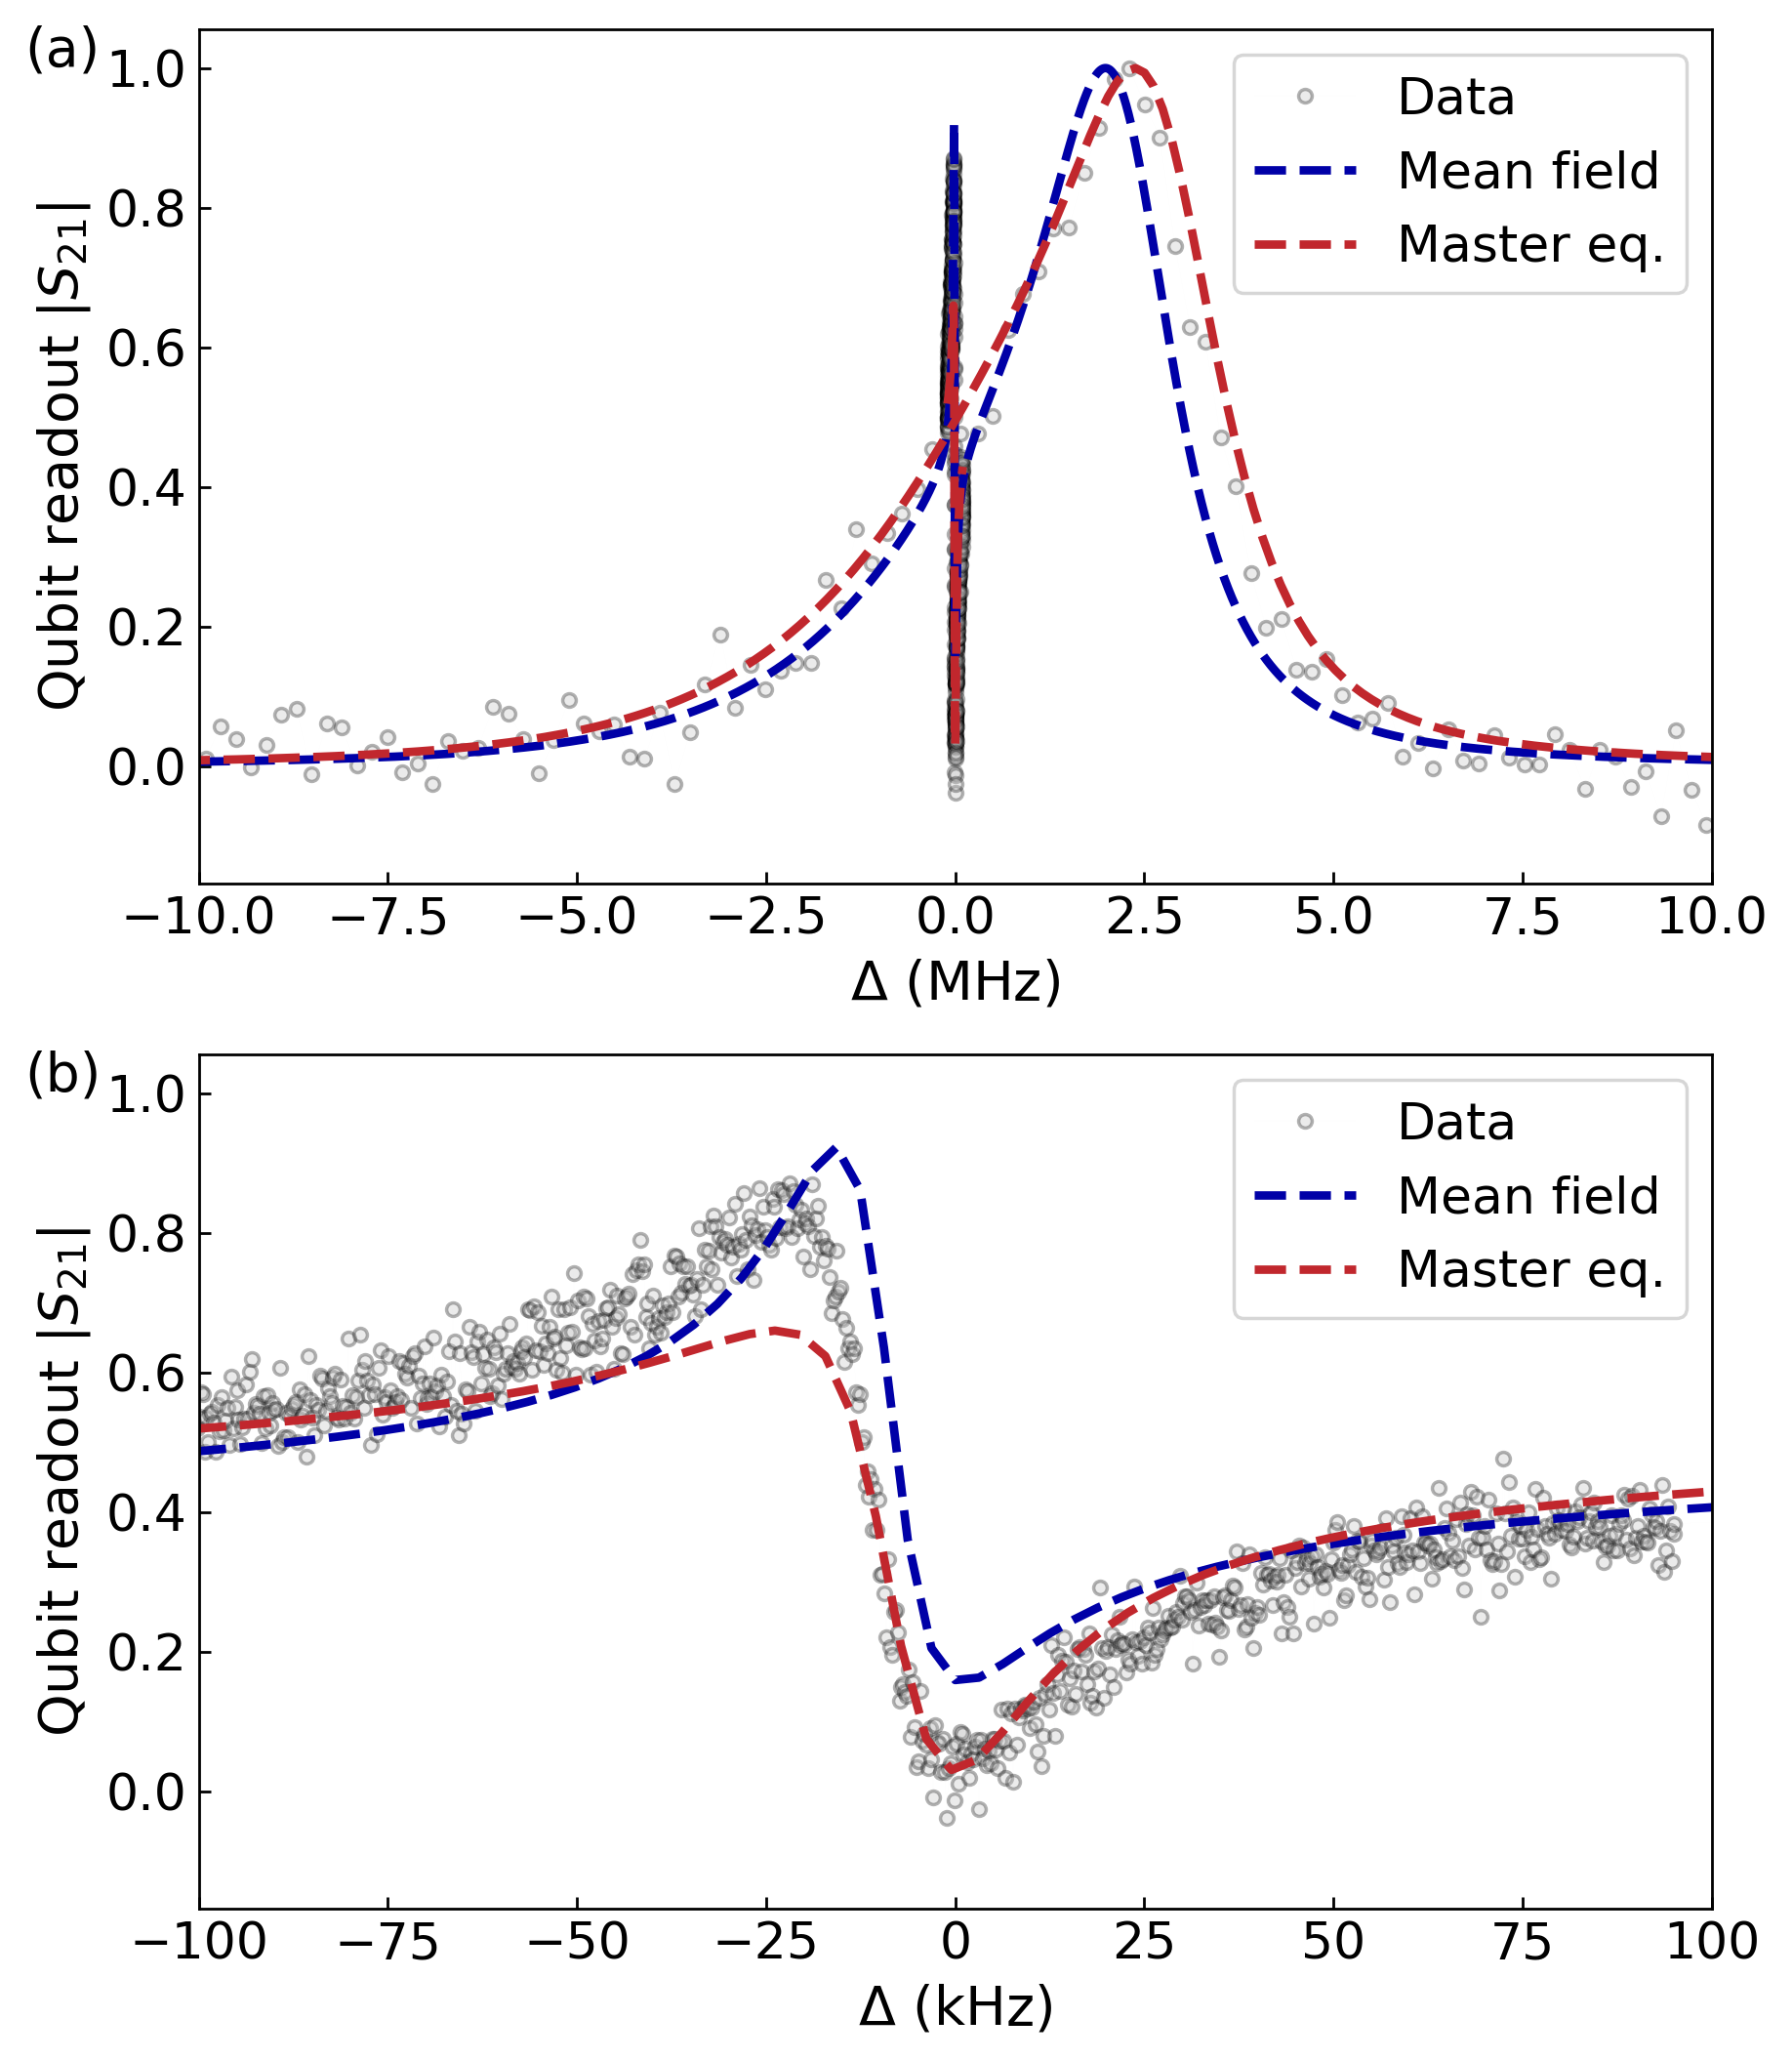

In [31]:
colors = cm.autumn(np.linspace(0.01, 0.5, 3))
# colors = ['#eb2e2e','#d7323c','#c43749','#b03b57','#9c3f64','#894472','#75487f','#614c8d','#4e519a','#3a55a8']
###     #c1272d - Dark Red,#0000a7 - Indigo,#eecc16 - Yellow,#008176 - Teal,#b3b3b3 - Light Gray
# colors = ['#008176','#0000a7','#c1272d'] 

colors = ['silver','#0000a7','#c1272d']
# colors = ['pink','#0000a7','#c1272d']
# colors = ['#edf2f4','#8d99ae','#2b2d42']
# colors = ['#edf2f4','tab:purple','#2b2d42']

font_axis_labels = 16
fntsize = 15;
#data_plot settings
data_marker = 4; data_color = colors[0]; data_color_edge = 'k'; data_ms = 'o'; data_lw = 0.01; data_alpha = 0.3
#MF plot settings:
MF_marker = 5;  MF_color = colors[1]; MF_lw = 2.5; MF_ls = '--'
#Master eq. plot settings:
ME_marker = 5;  ME_color = colors[2]; ME_lw = 2.5; ME_ls = '--'

#master equation stuff:
mm = 0;    nn = 0
delta_1 = np.linspace(-30,30,501)
delta = np.linspace(-delta_ab[0]-sigma, -delta_ab[0]+sigma,61)
Mast_eq_shift = 3.3225

#making the plot:
fig, (ax1,ax2) = plt.subplots(2, 1)#, figsize=(8,12))  
# fig.suptitle('dqb: ' + str(dqb_list[ii]), fontsize=20)


#plots
# ax1.plot(Freq_wide,S21_Norm(S21_wide[mm],S21[mm]),'g.', markersize=10)
ax1.plot(Freq_plt,S21dB/np.max(S21dB),marker = data_ms, markeredgecolor = data_color_edge,
         markerfacecolor = data_color, lw=data_lw, alpha= data_alpha, 
         label='Data',markersize=data_marker)   ### Data
ax1.plot(freq*10**(3), np.real(sp)[::-1]/np.max(np.real(sp)), color = MF_color,
         lw = MF_lw, ls = MF_ls,
         markersize=MF_marker, label='Mean field')
ax1.plot(delta + Mast_eq_shift, q_ss[nn,:]/np.max(q_ss_1[nn]), color = ME_color,
         lw = ME_lw, ls = ME_ls,
         markersize=ME_marker, label = 'Master eq.')
ax1.plot(delta_1+(delta_ab[0]-sigma),q_ss_1[nn,:]/np.max(q_ss_1[nn]), color= ME_color,
         lw = ME_lw, ls = ME_ls,
         markersize=ME_marker)

###Zoom on the phonon resonance
ax2.plot(Freq_plt*1e3,S21dB/np.max(S21dB),marker = data_ms, markeredgecolor = data_color_edge,
         markerfacecolor = data_color, lw=data_lw, alpha=data_alpha, 
         label='Data',markersize=data_marker)   ### Data
ax2.plot(freq*10**(6), np.real(sp)[::-1]/np.max(np.real(sp)), color = MF_color,
         lw = MF_lw, ls = MF_ls,
         markersize=MF_marker, label='Mean field')
ax2.plot((delta + Mast_eq_shift)*1e3, q_ss[nn,:]/np.max(q_ss_1[nn]),  color = ME_color,
         lw = ME_lw, ls = ME_ls,
         markersize=ME_marker, label = 'Master eq.')


#set axis, legend:
ax1.set_ylabel(r'Qubit readout $|S_{21}|$',fontsize = font_axis_labels); 
ax1.set_xlabel(r'$\Delta$ (MHz)',fontsize = font_axis_labels);
ax1.xaxis.set_tick_params(labelsize=fntsize); ax1.yaxis.set_tick_params(labelsize=fntsize)

ax2.set_ylabel(r'Qubit readout $|S_{21}|$',fontsize = font_axis_labels); 
ax2.set_xlabel(r'$\Delta$ (kHz)',fontsize = font_axis_labels);
ax2.xaxis.set_tick_params(labelsize=fntsize); ax2.yaxis.set_tick_params(labelsize=fntsize)

ax1.set_xlim([-10., 10.]);       ax2.set_xlim([-100, 100])
ax1.legend(loc='upper right');   ax2.legend(loc='upper right')

ax1.text(-0.09, 0.975, r'(a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax1.transAxes, color='k',)
ax2.text(-0.09, 0.975, r'(b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax2.transAxes, color='k',)

## Save data:
# plt.savefig('AIT_MF_fig3',bbox_inches = 'tight')

plt.show()